In [620]:
import sqlite3
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy import stats



def connect(sqlite_file):
    """ Make connection to an SQLite database file """
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()
    return conn, c


def close(conn):
    """ Commit changes and close connection to the database """
    # conn.commit()
    conn.close()





sqlite_file = 'my_first_db.sqlite'
table_name = 'my_table_3'

#connect to the database
conn, c = connect("FPA_FOD_20170508.sqlite")
num = 0
#find the number of Colorado fires
for row in conn.execute('SELECT * FROM Fires WHERE STATE = "CO";'):
    num+=1
       #print(row)
print(num)

#query for fires in CO and read from database into pandas dataframe
df = pd.read_sql_query('SELECT * from Fires Where STATE = "CO"', conn)


close(conn)

34157


# Descriptive Statistics

In [621]:
print("There are {} fires recorded in Colorado and {} attributes for each fire\n".format(df.shape[0], df.shape[1]))
print("The attributes and their data types are: \n")
for count in range(39):
    print(df.columns[count], " ", type(df.iloc[0][count]))
    


There are 34157 fires recorded in Colorado and 39 attributes for each fire

The attributes and their data types are: 

OBJECTID   <class 'numpy.int64'>
FOD_ID   <class 'numpy.int64'>
FPA_ID   <class 'str'>
SOURCE_SYSTEM_TYPE   <class 'str'>
SOURCE_SYSTEM   <class 'str'>
NWCG_REPORTING_AGENCY   <class 'str'>
NWCG_REPORTING_UNIT_ID   <class 'str'>
NWCG_REPORTING_UNIT_NAME   <class 'str'>
SOURCE_REPORTING_UNIT   <class 'str'>
SOURCE_REPORTING_UNIT_NAME   <class 'str'>
LOCAL_FIRE_REPORT_ID   <class 'str'>
LOCAL_INCIDENT_ID   <class 'str'>
FIRE_CODE   <class 'str'>
FIRE_NAME   <class 'str'>
ICS_209_INCIDENT_NUMBER   <class 'NoneType'>
ICS_209_NAME   <class 'NoneType'>
MTBS_ID   <class 'NoneType'>
MTBS_FIRE_NAME   <class 'NoneType'>
COMPLEX_NAME   <class 'NoneType'>
FIRE_YEAR   <class 'numpy.int64'>
DISCOVERY_DATE   <class 'numpy.float64'>
DISCOVERY_DOY   <class 'numpy.int64'>
DISCOVERY_TIME   <class 'str'>
STAT_CAUSE_CODE   <class 'numpy.float64'>
STAT_CAUSE_DESCR   <class 'str'>
CONT_DATE 

In [622]:
#create burn time stat by subtracting discovery day from contained day
burntime = []
for count in range(len(df)):
    time = (df.loc[count]["CONT_DOY"] - df.loc[count]["DISCOVERY_DOY"])
    if (time==0) or pd.isna(time):
        time = 1
    burntime.append(time)

df.insert(df.shape[1], "BURN_DAYS", burntime)

In [623]:
#check the first 5 entries of the dataframe
print(df.head(5))

   OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0        48      48  FS-1418940                FED   FS-FIRESTAT   
1        62      62  FS-1418976                FED   FS-FIRESTAT   
2        63      63  FS-1418978                FED   FS-FIRESTAT   
3       115     117  FS-1419150                FED   FS-FIRESTAT   
4       206     209  FS-1419344                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
0                    FS                USCOPSF   
1                    FS                USCOPSF   
2                    FS                USCOPSF   
3                    FS                USCOPSF   
4                    FS                USCOPSF   

              NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  \
0  Pike and San Isabel National Forest                  0212   
1  Pike and San Isabel National Forest                  0212   
2  Pike and San Isabel National Forest                  0212   
3  Pike and San Isabel National Fo

In [624]:
#Isolate key attributes and remove all other from dataframe
attributes = ["NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_NAME", "SOURCE_REPORTING_UNIT", "FIRE_YEAR", "DISCOVERY_DATE", "DISCOVERY_DOY", "DISCOVERY_TIME", 
             "STAT_CAUSE_CODE", "STAT_CAUSE_DESCR", "CONT_DATE", "CONT_DOY", "CONT_TIME", "FIRE_SIZE", "FIRE_SIZE_CLASS",
             "LATITUDE", "LONGITUDE", "OWNER_CODE", "FIRE_NAME", 'BURN_DAYS' ]


scatter_df = pd.DataFrame(df["FIRE_YEAR"])
attCount = 1
for item in attributes:
    if (item == "FIRE_YEAR"):
        continue
    scatter_df.insert(attCount, item, df[item])
    attCount += 1

## Visualization

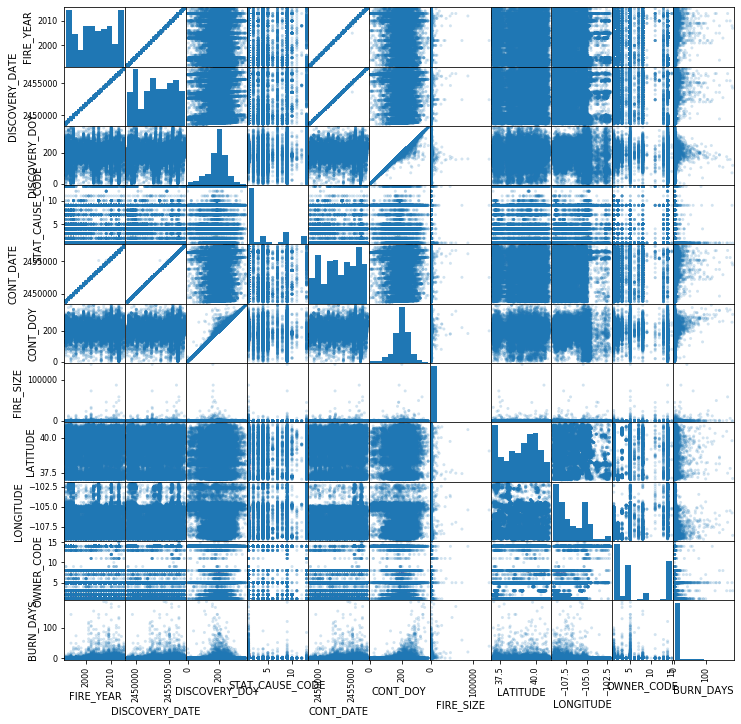

In [625]:
scatter_matrix(scatter_df, figsize = (12, 12), alpha = 0.2 )
pyplot.show()

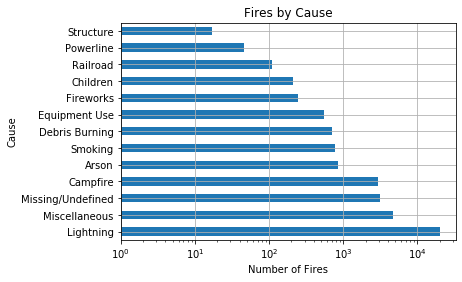

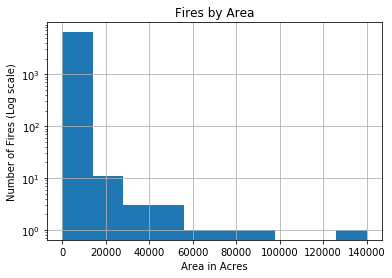

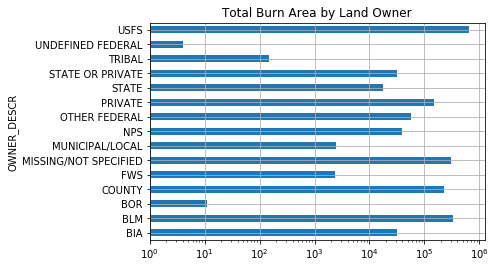

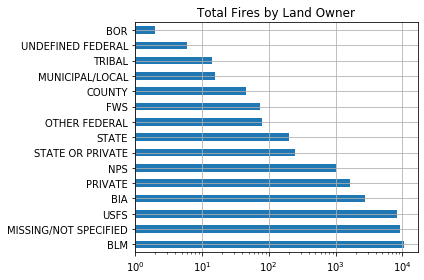

In [626]:
#isolate attributes
causes  = df["STAT_CAUSE_DESCR"]  
sizes = df["FIRE_SIZE"]

x = list(set(causes))

pyplot.title("Fires by Cause")
pyplot.xlabel("Number of Fires")
pyplot.ylabel("Cause")
causes.value_counts().plot(kind='barh', grid = True, log = True)
pyplot.savefig("Plots\Fire_by_cause.png")
pyplot.show()


pyplot.title("Fires by Area")
pyplot.xlabel("Area in Acres")
pyplot.ylabel("Number of Fires (Log scale)")
sizes.hist(range = (1, 140000), log = True, grid = True)
pyplot.savefig("Plots\Fires_by_area.png")
pyplot.show()


sum_by_owner = df.groupby('OWNER_DESCR')['FIRE_SIZE'].sum()
sum_by_owner.plot(kind = 'barh', log = True, grid = True)
pyplot.title("Total Burn Area by Land Owner")
pyplot.savefig("Plots\Area_by_owner.png")
pyplot.show()

total_by_owner = df['OWNER_DESCR'].value_counts()
total_by_owner.plot(kind = 'barh', log = True, grid = True)
pyplot.title("Total Fires by Land Owner")
pyplot.tight_layout()
pyplot.savefig("Plots\Fires_by_owner.png")
pyplot.show()

Fire Size Description before transformation
count     34157.000000
mean         53.936502
std        1266.686161
min           0.010000
25%           0.100000
50%           0.100000
75%           0.300000
max      137760.000000
Name: FIRE_SIZE, dtype: float64


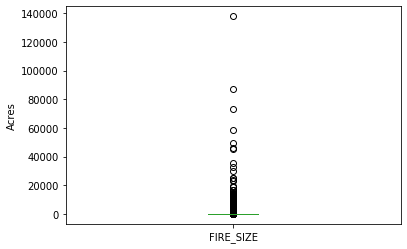

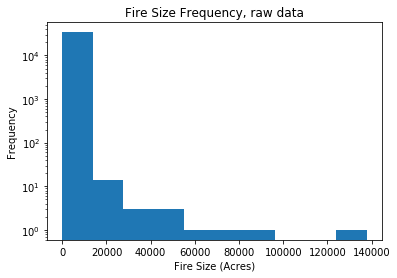

Skew coef:63.711528135334
Fire Size Description after transformation
count    34157.000000
mean         4.278675
std          1.904519
min          1.000000
25%          3.302585
50%          3.302585
75%          4.401197
max         17.438439
Name: FIRE_SIZE, dtype: float64


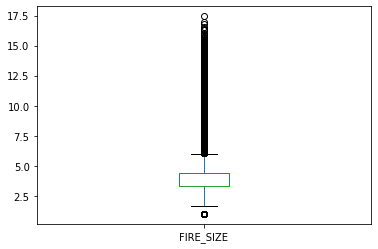

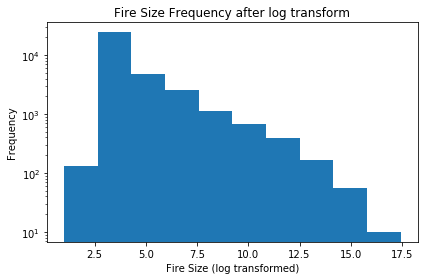

Skew coef:2.4414552397866127


In [627]:

#Fire Size transformation
print("Fire Size Description before transformation")
print(df['FIRE_SIZE'].describe())
df['FIRE_SIZE'].plot(kind = 'box')
pyplot.ylabel('Acres')
pyplot.savefig("Plots\size_box_before_log.png")
pyplot.show()
df['FIRE_SIZE'].plot(kind = 'hist', log = True)
pyplot.title("Fire Size Frequency, raw data")
pyplot.ylabel('Frequency')
pyplot.xlabel('Fire Size (Acres)')
pyplot.savefig("Plots\size_hist_before_log.png")
pyplot.show()
print("Skew coef:{}".format(df['FIRE_SIZE'].skew()))

log_fire_size = np.log(df['FIRE_SIZE'])
min_val = log_fire_size.min()
log_fire_size = log_fire_size + abs(min_val) + 1
print("Fire Size Description after transformation")
print(log_fire_size.describe())
log_fire_size.plot(kind = 'box')
pyplot.savefig("Plots\size_box_after_log.png")
pyplot.show()

log_fire_size.plot(kind = 'hist', log = True)
pyplot.title("Fire Size Frequency after log transform")
pyplot.ylabel('Frequency')
pyplot.xlabel('Fire Size (log transformed)')
pyplot.tight_layout()
pyplot.savefig("Plots\size_hist_after_log.png")
pyplot.show()
print("Skew coef:{}".format(log_fire_size.skew()))


STAT_CAUSE_DESCR
Arson                 10133.0
Campfire              11875.0
Children               1232.0
Debris Burning         8908.0
Equipment Use         19569.0
Fireworks               204.0
Lightning             87275.0
Miscellaneous        137760.0
Missing/Undefined     45000.0
Powerline              6600.0
Railroad                800.0
Smoking               10800.0
Structure                 6.0
Name: FIRE_SIZE, dtype: float64


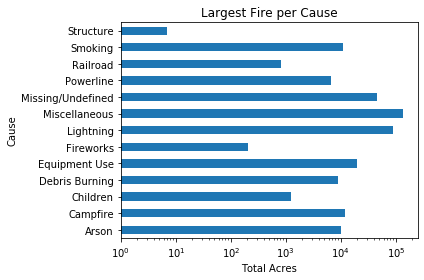

In [628]:
#Which causes are connected to the largest fires?
sum_by_cause = df.groupby('STAT_CAUSE_DESCR')['FIRE_SIZE'].max()
print(sum_by_cause)
sum_by_cause.plot(kind = 'barh', log = True)
pyplot.xlabel('Total Acres')
pyplot.ylabel('Cause')
pyplot.title('Largest Fire per Cause')
pyplot.tight_layout()
pyplot.savefig("Plots\Largest_burn_per_cause.png")
pyplot.show()

In [629]:
#How many fires were caused by lightning?
print(causes.value_counts())

Lightning            19945
Miscellaneous         4660
Missing/Undefined     3113
Campfire              2953
Arson                  844
Smoking                766
Debris Burning         708
Equipment Use          547
Fireworks              244
Children               208
Railroad               108
Powerline               45
Structure               16
Name: STAT_CAUSE_DESCR, dtype: int64


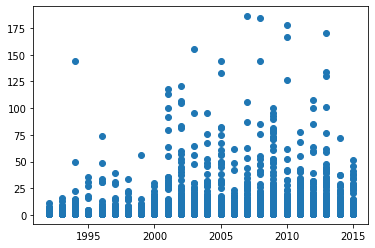

In [630]:
#What is the connection between burn days and cause?

pyplot.scatter(x =df['FIRE_YEAR'],y =df['BURN_DAYS'])

pyplot.show()

## Looking at feature trends over time

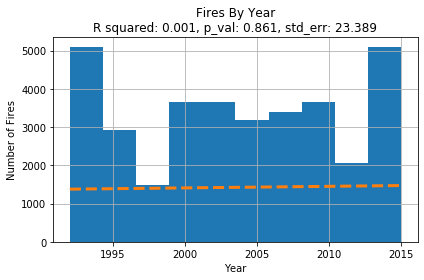

R squared: 0.00141585352879104
DescribeResult(nobs=34157, minmax=(1992, 2015), mean=2003.6390783733934, variance=48.18645503534355, skewness=-0.10714409092339815, kurtosis=-1.2513011910483223)


In [695]:
from scipy.stats import describe


pyplot.xlabel("Year")
pyplot.ylabel("Number of Fires")
fireyear = df['FIRE_YEAR']
(unique, counts) = np.unique(df['FIRE_YEAR'], return_counts=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(unique, counts)
axes = pyplot.gca()
x_vals = np.array(unique)
y_vals = intercept + slope * x_vals

fireyear.hist()
pyplot.plot(x_vals, y_vals, '--', linewidth = 3)


pyplot.title("Fires By Year\nR squared: {}, p_val: {}, std_err: {}".format(round((r_value*r_value), 3) , round(p_value, 3), round(std_err, 3)))
pyplot.tight_layout()
pyplot.savefig("Plots\Fires_by_year.png")
pyplot.show()
print("R squared: {}".format(r_value*r_value))
print(describe(fireyear))

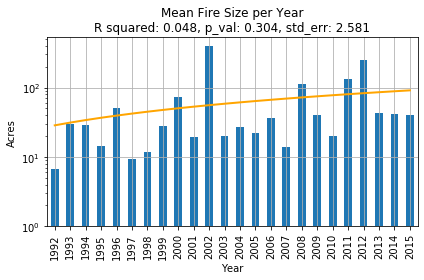

R squared:  0.0479539417001927
Slope:  2.716471204816308
DescribeResult(nobs=24, minmax=(5.636838124054501, 390.20618345617424), mean=59.74005672998118, variance=7694.065956799657, skewness=2.7599269583547676, kurtosis=7.110931971355626)


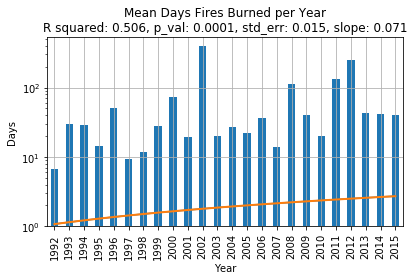

R squared: 0.5062038572262277
Slope:  0.07134238186356655
DescribeResult(nobs=24, minmax=(1.0665658093797277, 3.823529411764706), mean=1.8963331079500205, variance=0.5027357434469623, skewness=0.8948400327762612, kurtosis=0.24282201769015055)


In [697]:
#pyplot.scatter(df['FIRE_YEAR'], df['FIRE_SIZE'])
means_by_year_size = df.groupby('FIRE_YEAR')['FIRE_SIZE'].mean()

slope, intercept, r_value, p_value, std_err = stats.linregress(means_by_year_size.index.values, means_by_year_size.values)
axes = pyplot.gca()
x_vals = np.array(means_by_year_size.index.values)
y_vals = intercept + slope * x_vals

reg_line_df = pd.DataFrame()
reg_line_df['x_vals'] = x_vals
reg_line_df['y_vals'] = y_vals
reg_line_df['y_vals'].plot(grid = True, linewidth = 2, color = 'orange')
means_by_year_size.plot(kind= 'bar', log = True, grid = True)


pyplot.xlabel('Year')
pyplot.ylabel('Acres')
pyplot.title("Mean Fire Size per Year\nR squared: {}, p_val: {}, std_err: {}".format(round((r_value*r_value), 3) , round(p_value, 3), round(std_err, 3)))
pyplot.tight_layout()
pyplot.savefig("Plots\Average_size_per_year.png")
pyplot.show()
print("R squared: ", r_value*r_value)
print("Slope: ", slope)
print(describe(means_by_year_size))


#Mean days per year w/ regression
means_by_year_days = df.groupby('FIRE_YEAR')['BURN_DAYS'].mean()

slope, intercept, r_value, p_value, std_err = stats.linregress(means_by_year_days.index.values, means_by_year_days.values)
axes = pyplot.gca()
x_vals = np.array(means_by_year_days.index.values)
y_vals = intercept + slope * x_vals

reg_line_df = pd.DataFrame()
reg_line_df['x_vals'] = x_vals
reg_line_df['y_vals'] = y_vals
reg_line_df['y_vals'].plot()
reg_line_df['y_vals'].plot(linewidth = 2, grid = True)
means_by_year_size.plot(kind= 'bar', log = True, grid = True)


pyplot.xlabel('Year')
pyplot.ylabel('Days')
pyplot.title("Mean Days Fires Burned per Year\nR squared: {}, p_val: {}, std_err: {}, slope: {}".format(round((r_value*r_value), 3) , round(p_value, 4), round(std_err, 3), round(slope, 3)))
pyplot.tight_layout()
pyplot.savefig("Plots\Mean_burn_days_per_year.png")
pyplot.show()
print("R squared: {}".format(r_value*r_value))
print("Slope: ", slope)
print(describe(means_by_year_days))

FIRE_YEAR
1992    189.981846
1993    193.244373
1994    184.441750
1995    200.980224
1996    196.539502
1997    196.570637
1998    203.030065
1999    196.591270
2000    203.421865
2001    203.391785
2002    192.633907
2003    191.497523
2004    179.644275
2005    188.066667
2006    186.065350
2007    199.197196
2008    194.286700
2009    210.685924
2010    192.281737
2011    200.710554
2012    196.376130
2013    158.221880
2014    191.419569
2015    204.477157
Name: DISCOVERY_DOY, dtype: float64


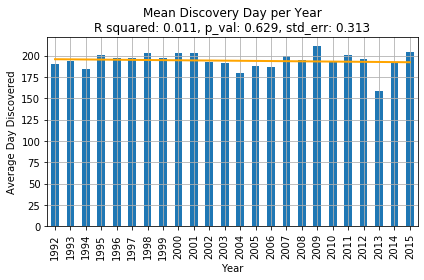

R squared: 0.010813923825493933
Slope:  -0.1534140311958191
DescribeResult(nobs=24, minmax=(158.22187981510015, 210.6859243697479), mean=193.90657852551684, variance=108.82203974964997, skewness=-1.5923039331469202, kurtosis=3.8836884008803594)


In [694]:
means_by_year_disc = df.groupby('FIRE_YEAR')['DISCOVERY_DOY'].mean()
print(means_by_year_disc)
slope, intercept, r_value, p_value, std_err = stats.linregress(means_by_year_disc.index.values, means_by_year_disc.values)
axes = pyplot.gca()
x_vals = np.array(means_by_year_disc.index.values)
y_vals = intercept + slope * x_vals

reg_line_df = pd.DataFrame()
reg_line_df['x_vals'] = x_vals
reg_line_df['y_vals'] = y_vals
reg_line_df['y_vals'].plot(color = 'orange', linewidth = 2)
means_by_year_disc.plot(kind= 'bar', log = False, grid = True)


pyplot.xlabel('Year')
pyplot.ylabel('Average Day Discovered')
pyplot.title("Mean Discovery Day per Year\nR squared: {}, p_val: {}, std_err: {}".format(round((r_value*r_value), 3) , round(p_value, 3), round(std_err, 3)))
pyplot.tight_layout()
pyplot.savefig("Plots\Mean_disc_day_per_year.png")
pyplot.show()
print("R squared: {}".format(r_value*r_value))
print("Slope: ", slope)
print(describe(means_by_year_disc))

## Create new dataframe with key attributes

In [634]:
#Isolate key attributes and remove all other from dataframe
attributes = ["NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_NAME", "SOURCE_REPORTING_UNIT", "FIRE_YEAR", "DISCOVERY_DATE", "DISCOVERY_DOY", "DISCOVERY_TIME", 
             "STAT_CAUSE_CODE", "STAT_CAUSE_DESCR", "CONT_DATE", "CONT_DOY", "CONT_TIME", "FIRE_SIZE", "FIRE_SIZE_CLASS",
             "LATITUDE", "LONGITUDE", "OWNER_CODE", "FIRE_NAME", 'BURN_DAYS' ]
print("{} key attributes".format(len(attributes)))





keydf = pd.DataFrame(df["FIRE_YEAR"])
attCount = 1
for item in attributes:
    if (item == "FIRE_YEAR"):
        continue
    keydf.insert(attCount, item, df[item])
    attCount += 1



print(keydf.columns)

19 key attributes
Index(['FIRE_YEAR', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_NAME',
       'SOURCE_REPORTING_UNIT', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'FIRE_NAME', 'BURN_DAYS'],
      dtype='object')


In [635]:
keydf.shape

(34157, 19)

## Baseline clustering method (by counties)

In [636]:
#clustered in QGIS
firecsv = pd.read_csv('cluster_by_counties_naive.csv')

In [637]:
#all sillhouette scores stored as [name_metric, silscore]
silScores = []
#cluster_ids stores cluster ids for each clustering method
cluster_ids = []

#holds the numerical index for the county, for classification
county_index = []

set_counties = list(set(county_df['county_2']))
#list with all county IDs
countyID = firecsv['county_2']
county_df = pd.DataFrame(countyID)
#create index number for every county
index_count = 0
for county in countyID:
    for index in range(len(set_counties)):
        if (county == set_counties[index]):
            county_index.append(index)
    
cluster_ids.append(county_index)

#list with all latlong coord points
latlong = []
for index in range(len(firecsv)):
    current = []
    current.append(firecsv['LATITUDE'].iloc[index])
    current.append(firecsv['LONGITUDE'].iloc[index])
    latlong.append(current)

In [638]:
silScoreCounty = silhouette_score(latlong, countyID)
print("Clustering by county produced {} clusters".format(len(set(countyID))))
print(silScoreCounty)
silScores.append(["County cluster", silScoreCounty])

Clustering by county produced 64 clusters
0.2501060363858666


In [639]:
#add burn days to county baseline df
burntime = []
for count in range(len(firecsv)):
    time = (firecsv.loc[count]["CONT_DOY"] - firecsv.loc[count]["DISCOVERY_DOY"])
    if (time==0) or pd.isna(time):
        time = 1
    burntime.append(time)

firecsv['BURN_DAYS'] = burntime

## Split latitiude and longitude for clustering

In [640]:
coordPairs = []

lat = keydf["LATITUDE"]
long = keydf["LONGITUDE"]

for index in range(len(lat)):
    thisPair = []
    thisPair.append(lat[index])
    thisPair.append(long[index])
    coordPairs.append(thisPair)

## K-means clustering

In [641]:
Kmeans = []


kmeans12 = pd.read_csv('Kmeans, 12 clusters.csv')
kmeans24 = pd.read_csv('Kmeans, 24 clusters.csv')
kmeans48 = pd.read_csv('Kmeans, 48 clusters.csv')
kmeans64 = pd.read_csv('Kmeans, 64 clusters.csv')

C:\Users\dmruss\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [642]:
silScore12 = silhouette_score(coordPairs, kmeans12['CLUSTER_ID'])
silScore24 = silhouette_score(coordPairs, kmeans24['CLUSTER_ID'])
silScore48 = silhouette_score(coordPairs, kmeans48['CLUSTER_ID'])
silScore64 = silhouette_score(coordPairs, kmeans64['CLUSTER_ID'])

print(silScore12)
silScores.append(["Kmeans_12", silScore12])
cluster_ids.append(kmeans12['CLUSTER_ID'])
print("Kmeans 12 produced {} clusters".format(set(kmeans12['CLUSTER_ID'])))

print(silScore24)
silScores.append(["Kmeans_24", silScore24])
cluster_ids.append(kmeans24['CLUSTER_ID'])
print("Kmeans 24 produced {} clusters".format(set(kmeans24['CLUSTER_ID'])))

print(silScore48)
silScores.append(["Kmeans_48", silScore48])
cluster_ids.append(kmeans48['CLUSTER_ID'])
print("Kmeans 48 produced {} clusters".format(set(kmeans48['CLUSTER_ID'])))

print(silScore64)
silScores.append(["Kmeans_64", silScore64])
cluster_ids.append(kmeans64['CLUSTER_ID'])
print("Kmeans 64 produced {} clusters".format(set(kmeans64['CLUSTER_ID'])))


0.4361026651015461
Kmeans 12 produced {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} clusters
0.43823814499905556
Kmeans 24 produced {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} clusters
0.41453755294268263
Kmeans 48 produced {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47} clusters
0.4073260693817555
Kmeans 64 produced {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63} clusters


## Agglomerative Hierarchical Clustering

[39.29222222, -105.18305556]
362
0.35703718425820863


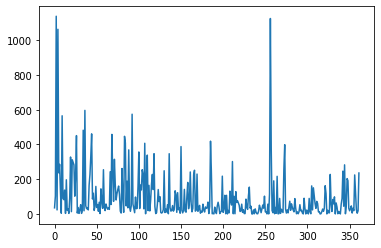

In [643]:
Agg = []

clusterID = []

    
print(coordPairs[0])
distThresh = 0.2
agg_clustering_2 = AgglomerativeClustering(n_clusters=None, affinity='euclidean', 
                                      memory=None, connectivity=None, compute_full_tree= True, linkage='average', 
                                      distance_threshold=distThresh).fit(coordPairs)

silScore = silhouette_score(coordPairs, agg_clustering_2.labels_)


print(agg_clustering_2.n_clusters_)
print(silhouette_score(coordPairs, agg_clustering_2.labels_))

silScores.append(["Agg_0.2", silScore])
cluster_ids.append(agg_clustering_2.labels_)
keydf['CLUSTER_ID'] = agg_clustering_2.labels_
keydf.to_csv('Agg_0.2.csv')

(unique, counts) = np.unique(agg_clustering_2.labels_, return_counts=True)
pyplot.plot(unique, counts)

105
0.35406891529517887


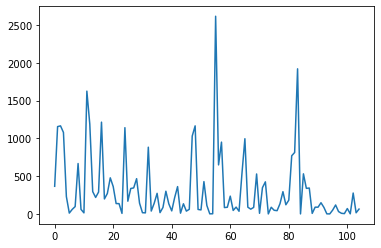

In [644]:
distThresh = 0.4
agg_clustering_4 = AgglomerativeClustering(n_clusters=None, affinity='euclidean', 
                                      memory=None, connectivity=None, compute_full_tree= True, linkage='average', 
                                      distance_threshold=distThresh).fit(coordPairs)
silScore = silhouette_score(coordPairs, agg_clustering_4.labels_)

print(agg_clustering_4.n_clusters_)
print(silhouette_score(coordPairs, agg_clustering_4.labels_))


(unique, counts) = np.unique(agg_clustering_4.labels_, return_counts=True)
pyplot.plot(unique, counts)

silScores.append(["Agg_0.4", silScore])
cluster_ids.append(agg_clustering_2.labels_)

keydf['CLUSTER_ID'] = agg_clustering_4.labels_
keydf.to_csv('Agg_0.4.csv')

49
0.3722605169890916


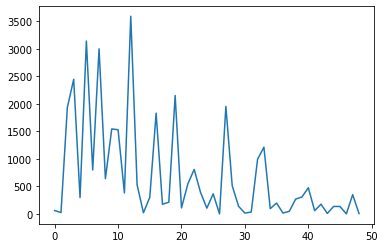

In [645]:
distThresh = 0.6
agg_clustering_6 = AgglomerativeClustering(n_clusters=None, affinity='euclidean', 
                                      memory=None, connectivity=None, compute_full_tree= True, linkage='average', 
                                      distance_threshold=distThresh).fit(coordPairs)
silScore = silhouette_score(coordPairs, agg_clustering_6.labels_)

print(agg_clustering_6.n_clusters_)
print(silScore)

(unique, counts) = np.unique(agg_clustering_6.labels_, return_counts=True)
pyplot.plot(unique, counts)

silScores.append(["Agg_0.6", silScore])
cluster_ids.append(agg_clustering_2.labels_)

keydf.to_csv('Agg_0.6.csv')

## DBSCAN 

In [646]:


#import csv with clusterID created in qgis
DBSCANs = []
DBSCAN_coords_clusterids = []

dbscan_50_06 = pd.read_csv('DBSCAN_50_0.06.csv')
dbscan_50_06.name = "DBSCAN_50_0.06"
DBSCANs.append(dbscan_50_06)
dbscan_50_08 = pd.read_csv('DBSCAN_50_0.08.csv')
dbscan_50_08.name = "DBSCAN_50_0.08"
DBSCANs.append(dbscan_50_08)
dbscan_50_1 = pd.read_csv('DBSCAN_50_0.1.csv')
dbscan_50_1.name = "DBSCAN_50_0.1"
DBSCANs.append(dbscan_50_1)

dbscan_100_06 = pd.read_csv('DBSCAN_100_0.06.csv')
dbscan_100_06.name = "DBSCAN_100_0.06"
DBSCANs.append(dbscan_100_06)
dbscan_100_08 = pd.read_csv('DBSCAN_100_0.08.csv')
dbscan_100_08.name = "DBSCAN_100_0.08"
DBSCANs.append(dbscan_100_08)
dbscan_100_1 = pd.read_csv('DBSCAN_100_0.1.csv')
dbscan_100_1.name = "DBSCAN_100_0.1"
DBSCANs.append(dbscan_100_1)

dbscan_150_06 = pd.read_csv('DBSCAN_150_0.06.csv')
dbscan_150_06.name = "DBSCAN_150_0.06"
DBSCANs.append(dbscan_150_06)
dbscan_150_08 = pd.read_csv('DBSCAN_150_0.08.csv')
dbscan_150_08.name = "DBSCAN_150_0.08"
DBSCANs.append(dbscan_150_08)
dbscan_150_1 = pd.read_csv('DBSCAN_150_0.1.csv')
dbscan_150_1.name = "DBSCAN_150_0.1"
DBSCANs.append(dbscan_150_1)




In [647]:
for scan in DBSCANs:
    current = []
    coordinates = pd.DataFrame()
    coordinates['LATITUDE'] = scan['LATITUDE']
    coordinates['LONGITUDE'] = scan['LONGITUDE']
    current.append(coordinates)
    current.append(scan['CLUSTER_ID'])
    DBSCAN_coords_clusterids.append(current)
    s = silhouette_score(coordinates, scan['CLUSTER_ID'])
    silScores.append([scan.name, s])
    print(scan.name, len(set(scan['CLUSTER_ID'])), s)

DBSCAN_50_0.06 53 0.09020269217320695
DBSCAN_50_0.08 35 0.1764354022329947
DBSCAN_50_0.1 21 0.1712351610158417
DBSCAN_100_0.06 33 0.6472069031970081
DBSCAN_100_0.08 32 0.34243904986163204
DBSCAN_100_0.1 23 0.12689611153079203
DBSCAN_150_0.06 8 0.8250891760080648
DBSCAN_150_0.08 30 0.5774105158023479
DBSCAN_150_0.1 23 0.2612176409457889


In [648]:
min_val = np.log(DBSCANs[0]['FIRE_SIZE']).min()
print((np.log(DBSCANs[1]['FIRE_SIZE']) + abs(min_val) +1).describe())

count    27494.000000
mean         4.151486
std          1.748262
min          1.000000
25%          3.302585
50%          3.302585
75%          4.401197
max         17.438439
Name: FIRE_SIZE, dtype: float64


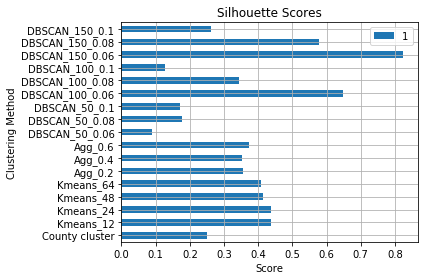

In [649]:
sScores = pd.DataFrame(silScores)
ax = sScores.plot(kind = 'barh', grid = True)
ax.set_yticklabels(sScores[0])
pyplot.title("Silhouette Scores")
pyplot.xlabel("Score")
pyplot.ylabel("Clustering Method")
pyplot.tight_layout()
pyplot.savefig("Plots\sil_scores.png")
pyplot.show()



## Splitting data for training and validation

In [650]:
#replace fire size column with log adjusted fire sizes
firecsv['FIRE_SIZE'] = log_fire_size
keydf['FIRE_SIZE'] = log_fire_size

In [651]:
#format: cluster method, accuracy, precision, recall, f-1score
KNNs_training = []
predict_accuracy_f1 = []

In [652]:
means_std_dev = []
#keydf['CLUSTER_ID'] = cluster_ids[1]
print(firecsv['BURN_DAYS'])

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
34145    1.0
34146    1.0
34147    1.0
34148    1.0
34149    1.0
Name: BURN_DAYS, Length: 34150, dtype: float64


In [671]:
>>> from sklearn.dummy import DummyClassifier
cluster_name = ['Baseline, by counties', 'Kmeans_12', 'Kmeans_24', 'Kmeans_48', 'Kmeans_64', 'Agg_0.2', 'Agg_0.4', 'Agg_0.6']


for index in range(len(cluster_ids)):
    print(cluster_name[index])
    
    if (index == 0):  #different size dataframe, some were removed due to location
        firecsv['CLUSTER_ID'] = cluster_ids[index]
        X = firecsv.loc[:,["FIRE_SIZE", "FIRE_YEAR", "BURN_DAYS", "CLUSTER_ID", "DISCOVERY_DOY", "OWNER_CODE"]]
        Y = firecsv.loc[:, "STAT_CAUSE_CODE"]
        
    else:
        keydf['CLUSTER_ID'] = cluster_ids[index]
        X = keydf.loc[:,["FIRE_SIZE", "FIRE_YEAR", "BURN_DAYS", "CLUSTER_ID", "DISCOVERY_DOY", "OWNER_CODE"]]
        Y = keydf.loc[:, "STAT_CAUSE_CODE"]
        
   
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.20, random_state=1)

    models = []
    models.append(('MF Baseline', DummyClassifier(strategy="most_frequent") )) 
    #models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('CNN', MLPClassifier(solver='adam')))
    models.append(('SVM', SVC()))
    # evaluate each model in turn
    results = []
    names = []
    means_and_std_dev = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        current = []
        current.append(name)
        current.append(cv_results.mean())
        current.append(cv_results.std())
        means_and_std_dev.append(current)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    means_std_dev.append(means_and_std_dev) #append all classifier results to total classifier list
    
    #predict using baseline
    if (index is 0):
        model = DummyClassifier(strategy="most_frequent")
        model.fit(X_train, Y_train)
        predictions = model.predict(X_validation)
        
        current = []
        current.append("MF Baseline")
        current.append(accuracy_score(Y_validation, predictions))
        current.append(f1_score(Y_validation, predictions, average = 'weighted'))

        predict_accuracy_f1.append(current)
        print(accuracy_score(Y_validation, predictions))
    
    
    #predict using KNN
    model = KNeighborsClassifier()
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    mean_accuracy = accuracy_score(Y_validation, predictions)
    f1 = f1_score(Y_validation, predictions, average = 'weighted')
    # Evaluate predictions
    print(mean_accuracy)
    
    #append name and mean accuracy to total prediction accuracy f1 list
    current = []
    current.append(cluster_name[index])
    current.append(mean_accuracy)
    current.append(f1)
    predict_accuracy_f1.append(current)
    
    

    #print(confusion_matrix(Y_validation, predictions))
    #print(classification_report(Y_validation, predictions))

Baseline, by counties
MF Baseline: 0.584591 (0.000689)
LDA: 0.719985 (0.004296)
KNN: 0.742787 (0.005056)
CART: 0.708493 (0.004208)
NB: 0.536605 (0.146534)
CNN: 0.584739 (0.150342)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


KeyboardInterrupt: 

In [716]:
print(means_std_dev[0])

[['MF Baseline', 0.5845909015066084, 0.0006888236423353936], ['LDA', 0.719984675025673, 0.0042961663147680395], ['KNN', 0.742786691874531, 0.005056231506688555], ['CART', 0.7075046223506021, 0.004055512325255524], ['NB', 0.5366054494837955, 0.14653382430333398], ['CNN', 0.6132871228771529, 0.03531311882576185]]


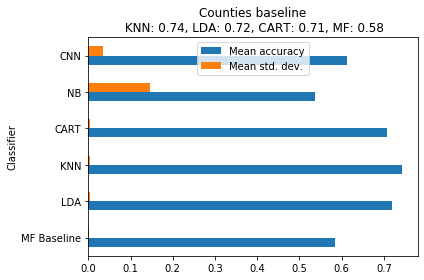

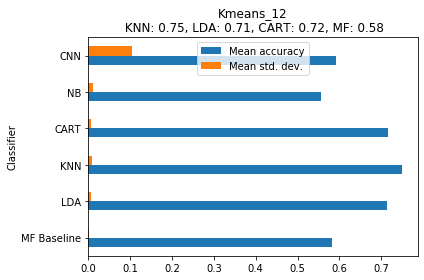

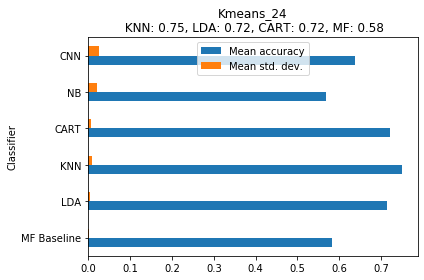

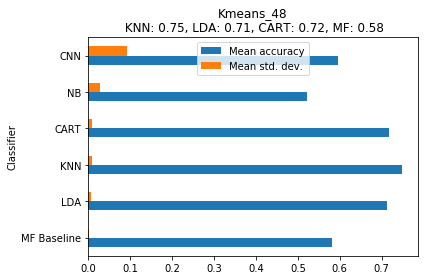

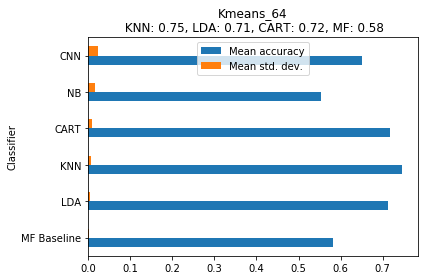

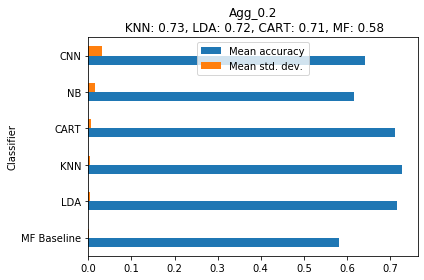

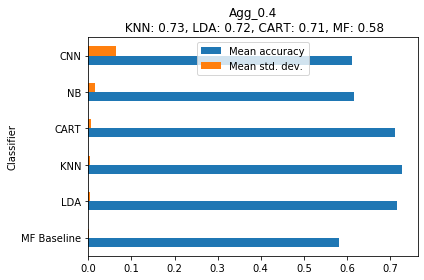

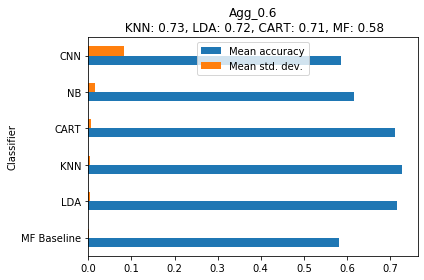

In [721]:
#Graphs evaluating which classifier had the highest accuracy for each clustering method
cluster_name = ['Counties baseline', 'Kmeans_12', 'Kmeans_24', 'Kmeans_48', 'Kmeans_64', 'Agg_0.2', 'Agg_0.4', 'Agg_0.6']
count = 0

KNNs_training.append(means_std_dev[0][0])

for cluster in means_std_dev:
    first = pd.DataFrame(cluster)
    ax = first.plot(kind='barh')
    ax.set_yticklabels(names)
    pyplot.title("{}\n KNN: {}, LDA: {}, CART: {}, MF: {}".format((cluster_name[count]), round(cluster[2][1], 2), round(cluster[1][1], 2), round(cluster[3][1], 2), round(cluster[0][1], 2)))
    ax.legend(["Mean accuracy", "Mean std. dev."], loc = 'upper center')
    pyplot.ylabel('Classifier')
    pyplot.tight_layout()
    pyplot.savefig("Plots\{}_class_accuracy.png".format(cluster_name[count]))
    pyplot.show()
    
    #append KNN accuracy and std dev for each clustering method
    current = []
    current.append(cluster_name[count])
    current.append(cluster[2][1])
    current.append(cluster[2][2])
    KNNs_training.append(current)
    count += 1
    
    


## Classifiers with DBSCAN

In [655]:
db_means_std = []

count = 0
for scan in DBSCANs:
    print(scan.name)
    burntime = []
    for count in range(len(scan)):
        time = (scan.loc[count]["CONT_DOY"] - scan.loc[count]["DISCOVERY_DOY"])
        if (time==0) or pd.isna(time):
            time = 1
        burntime.append(time)

    scan['BURN_DAYS'] = burntime
    
    #log transform fire_size to reduce skewness, shift to positive
    min_val = np.log(scan['FIRE_SIZE'].min())
    scan['FIRE_SIZE'] = (np.log(scan['FIRE_SIZE']) + abs(min_val) + 1)
    
    #slice 
    X = scan.loc[:,["FIRE_SIZE", "FIRE_YEAR", "BURN_DAYS", "CLUSTER_ID", "DISCOVERY_DOY", "OWNER_CODE"]]
    Y = scan.loc[:, "STAT_CAUSE_CODE"]
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.20, random_state=1)

    models = []
    models.append(('MF Baseline', DummyClassifier(strategy="most_frequent") )) 
    #models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('CNN', MLPClassifier(solver='adam')))
    #models.append(('SVM', SVC(gamma='auto')))
    # evaluate each model in turn
    results = []
    names = []
    means_and_std_dev = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        current = []
        current.append(name)
        current.append(cv_results.mean())
        current.append(cv_results.std())
        means_and_std_dev.append(current)
        print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    db_means_std.append(means_and_std_dev)
    
    #predict with KNN
    model = KNeighborsClassifier()
    model.fit(X_train, Y_train)
    predictions = model.predict(X_validation)
    mean_accuracy = accuracy_score(Y_validation, predictions)
    f1 = f1_score(Y_validation, predictions, average='weighted')
    # Evaluate predictions
    print(mean_accuracy)
    
    #append KNN mean accuracy to final mean accuracy list
    current = []
    current.append(scan.name)
    current.append(mean_accuracy)
    current.append(f1)
    predict_accuracy_f1.append(current)
    count += 1
    print('\n')

DBSCAN_50_0.06
MF Baseline: 0.611323 (0.001024)
LDA: 0.746187 (0.006808)
KNN: 0.780380 (0.006330)
CART: 0.756870 (0.008794)
NB: 0.635036 (0.027899)
CNN: 0.640571 (0.056252)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7887354810431734


DBSCAN_50_0.08
MF Baseline: 0.610231 (0.000679)
LDA: 0.747170 (0.004364)
KNN: 0.779316 (0.005948)
CART: 0.752218 (0.006762)
NB: 0.176494 (0.004581)
CNN: 0.673074 (0.028871)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7765048190580105


DBSCAN_50_0.1
MF Baseline: 0.603723 (0.000986)
LDA: 0.721796 (0.005287)
KNN: 0.774623 (0.006130)
CART: 0.745709 (0.006875)
NB: 0.583282 (0.014782)
CNN: 0.644127 (0.063321)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.764606836167705


DBSCAN_100_0.06


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


MF Baseline: 0.623110 (0.001954)
LDA: 0.775590 (0.008053)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KNN: 0.797698 (0.009289)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


CART: 0.791988 (0.002743)
NB: 0.650257 (0.186202)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


CNN: 0.728133 (0.021103)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7968620974401321


DBSCAN_100_0.08
MF Baseline: 0.620141 (0.001371)
LDA: 0.757493 (0.004922)
KNN: 0.789696 (0.007241)
CART: 0.766135 (0.008031)
NB: 0.581924 (0.098639)
CNN: 0.669137 (0.092582)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7989852621406137


DBSCAN_100_0.1
MF Baseline: 0.622325 (0.001060)
LDA: 0.750882 (0.005286)
KNN: 0.785276 (0.004581)
CART: 0.754328 (0.007095)
NB: 0.587322 (0.144355)
CNN: 0.674489 (0.041470)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7915520628683693


DBSCAN_150_0.06
MF Baseline: 0.714400 (0.006792)
LDA: 0.790187 (0.009552)
KNN: 0.829222 (0.018491)
CART: 0.825590 (0.012531)
NB: 0.134384 (0.014329)
CNN: 0.732978 (0.091364)
0.8373893805309734


DBSCAN_150_0.08


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_

MF Baseline: 0.617933 (0.001956)
LDA: 0.765042 (0.004525)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KNN: 0.794453 (0.009187)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


CART: 0.770965 (0.005788)
NB: 0.101395 (0.009206)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


CNN: 0.608418 (0.162901)


C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.7832093517534537


DBSCAN_150_0.1
MF Baseline: 0.626190 (0.001034)
LDA: 0.750430 (0.009464)
KNN: 0.784684 (0.010002)
CART: 0.763486 (0.009222)
NB: 0.582051 (0.031317)
CNN: 0.676648 (0.039976)
0.794061757719715




C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


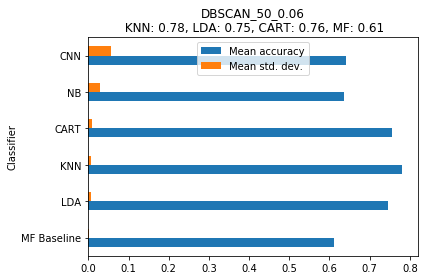

['DBSCAN_50_0.06', 0.7803798241168417, 0.006329714954514987]


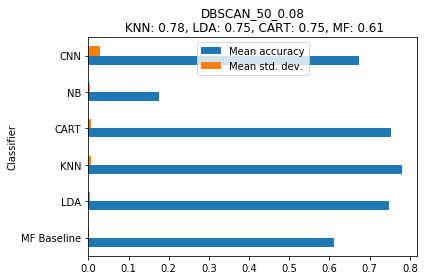

['DBSCAN_50_0.08', 0.7793163398535483, 0.005947564738498186]


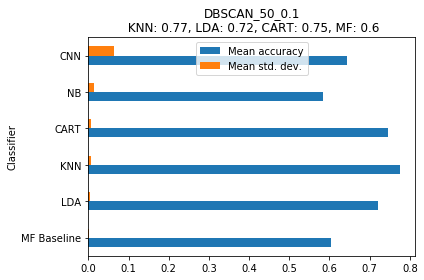

['DBSCAN_50_0.1', 0.7746232484959161, 0.006129628236186881]


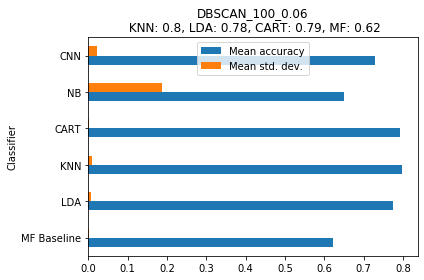

['DBSCAN_100_0.06', 0.7976977380443555, 0.009288662450799571]


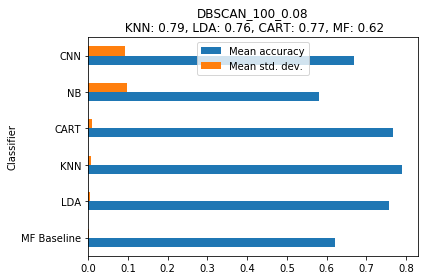

['DBSCAN_100_0.08', 0.7896955597273793, 0.007240539999220914]


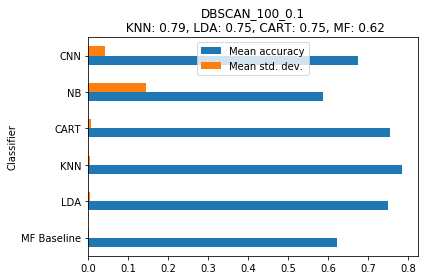

['DBSCAN_100_0.1', 0.7852755888182277, 0.004580512966748575]


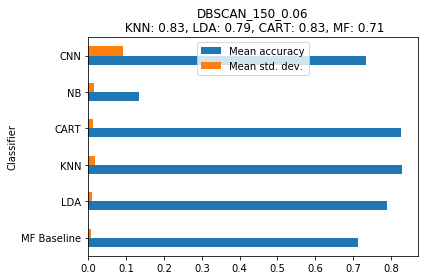

['DBSCAN_150_0.06', 0.829221954931812, 0.018491038901607384]


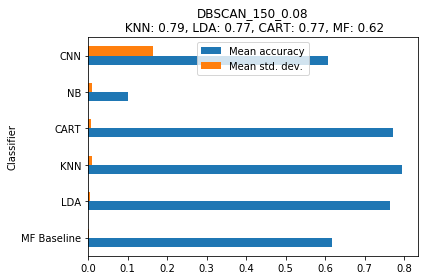

['DBSCAN_150_0.08', 0.7944528993073515, 0.009187040526386818]


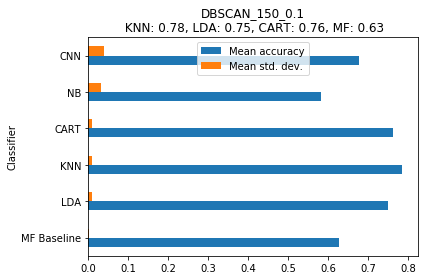

['DBSCAN_150_0.1', 0.7846841364491532, 0.01000228773880888]


In [722]:
#make plots for all classifiers using dbscan clustered points as input

count = 0
for cluster in db_means_std:
    first = pd.DataFrame(cluster)
    ax = first.plot(kind='barh')
    ax.set_yticklabels(names)
    pyplot.title("{}\n KNN: {}, LDA: {}, CART: {}, MF: {}".format((DBSCANs[count].name), round(cluster[2][1], 2), round(cluster[1][1], 2), round(cluster[3][1], 2), round(cluster[0][1], 2)))
    ax.legend(["Mean accuracy", "Mean std. dev."], loc = 'upper center')
    pyplot.ylabel('Classifier')
    pyplot.tight_layout()
    pyplot.savefig("Plots\{}_class_accuracy.png".format(DBSCANs[count].name))
    pyplot.show()
    
    current = []
    current.append(DBSCANs[count].name)
    current.append(cluster[2][1])
    current.append(cluster[2][2])
    KNNs_training.append(current)
    print(current)
    
    count += 1


18


In [663]:
#remove clustering methods which did not contain enough class members to converge
#DBSCAN_100_0.06
#DBSCAN_150_0.08

removed = 0
for index in range(0,18):
    if (removed == 2):
        break
    if (KNNs_training[index][0] == 'DBSCAN_100_0.06'):
        KNNs_training.pop(index)
        removed += 1
    if (KNNs_training[index][0] == 'DBSCAN_150_0.08'):
        KNNs_training.pop(index)
        removed += 1
removed = 0
for index in range(0,18):
    if (removed == 2):
        break
    if (predict_accuracy_f1[index][0] == 'DBSCAN_100_0.06'):
        predict_accuracy_f1.pop(index)
        removed += 1
    if (predict_accuracy_f1[index][0] == 'DBSCAN_150_0.08'):
        predict_accuracy_f1.pop(index)
        removed += 1

In [664]:
print(predict_accuracy_f1)

[['MF Baseline', 0.5811127379209371, 0.4271574139842947], ['Baseline, by counties', 0.7494875549048317, 0.7225434201805289], ['Kmeans_12', 0.7483899297423887, 0.7259460978858295], ['Kmeans_24', 0.754976580796253, 0.7321928958457574], ['Kmeans_48', 0.7520491803278688, 0.7296013131314895], ['Kmeans_64', 0.7535128805620609, 0.7299203013976228], ['Agg_0.2', 0.7365339578454333, 0.7096267915118579], ['Agg_0.4', 0.7365339578454333, 0.7096267915118579], ['Agg_0.6', 0.7365339578454333, 0.7096267915118579], ['DBSCAN_50_0.06', 0.7887354810431734, 0.7638290909573625], ['DBSCAN_50_0.08', 0.7765048190580105, 0.752117280010705], ['DBSCAN_50_0.1', 0.764606836167705, 0.73613945080954], ['DBSCAN_100_0.08', 0.7989852621406137, 0.7757075962068628], ['DBSCAN_100_0.1', 0.7915520628683693, 0.7667274508805394], ['DBSCAN_150_0.06', 0.8373893805309734, 0.8161814371109247], ['DBSCAN_150_0.1', 0.794061757719715, 0.7686822576030222]]


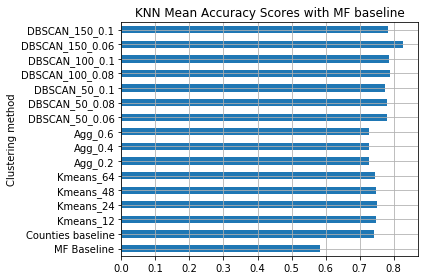

In [665]:
#KNN accuracy for training data
KNN_df = pd.DataFrame(KNNs_training)
ax = KNN_df[1].plot(kind='barh', grid = True)
ax.set_yticklabels(KNN_df[0])
pyplot.title('KNN Mean Accuracy Scores with MF baseline')
pyplot.ylabel('Clustering method')
pyplot.tight_layout()
pyplot.savefig("Plots\KNN_mean_accuracy.png")
pyplot.show()

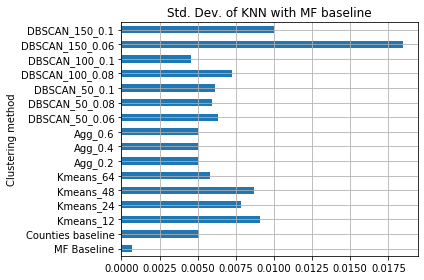

In [666]:
ax = KNN_df[2].plot(kind='barh', grid = True)
ax.set_yticklabels(KNN_df[0])
pyplot.title('Std. Dev. of KNN with MF baseline')
pyplot.ylabel('Clustering method')
pyplot.tight_layout()
pyplot.savefig("Plots\KNN_std_dev.png")
pyplot.show()

In [723]:
print(predict_accuracy_f1)
print(len(predict_accuracy_f1))

[['MF Baseline', 0.5811127379209371, 0.4271574139842947], ['Baseline, by counties', 0.7494875549048317, 0.7225434201805289], ['Kmeans_12', 0.7483899297423887, 0.7259460978858295], ['Kmeans_24', 0.754976580796253, 0.7321928958457574], ['Kmeans_48', 0.7520491803278688, 0.7296013131314895], ['Kmeans_64', 0.7535128805620609, 0.7299203013976228], ['Agg_0.2', 0.7365339578454333, 0.7096267915118579], ['Agg_0.4', 0.7365339578454333, 0.7096267915118579], ['Agg_0.6', 0.7365339578454333, 0.7096267915118579], ['DBSCAN_50_0.06', 0.7887354810431734, 0.7638290909573625], ['DBSCAN_50_0.08', 0.7765048190580105, 0.752117280010705], ['DBSCAN_50_0.1', 0.764606836167705, 0.73613945080954], ['DBSCAN_100_0.08', 0.7989852621406137, 0.7757075962068628], ['DBSCAN_100_0.1', 0.7915520628683693, 0.7667274508805394], ['DBSCAN_150_0.06', 0.8373893805309734, 0.8161814371109247], ['DBSCAN_150_0.1', 0.794061757719715, 0.7686822576030222]]
16


0.75631039608245


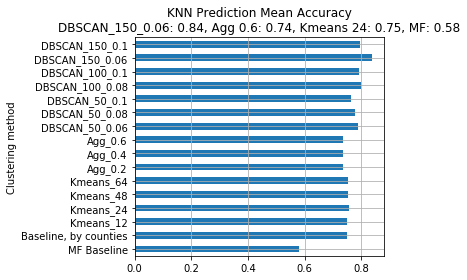

In [742]:
predict_mean_accuracy = pd.DataFrame(predict_accuracy_f1)
print(predict_mean_accuracy[1].mean())
ax = predict_mean_accuracy[1].plot(kind='barh', grid = True)
ax.set_yticklabels(predict_mean_accuracy[0])
#fig.tight_layout(rect=[0, 0.03, 4, 0.95])
pyplot.title('KNN Prediction Mean Accuracy\nDBSCAN_150_0.06: {}, Agg 0.6: {}, Kmeans 24: {}, MF: {}'.format(round(predict_accuracy_f1[14][1], 2), round(predict_accuracy_f1[8][1], 2), round(predict_accuracy_f1[3][1], 2), round(predict_accuracy_f1[0][1], 2)))
pyplot.ylabel('Clustering method')
pyplot.tight_layout()
pyplot.savefig("Plots\KNN_pred_mean_accuracy.png")
pyplot.show()

0.7234766487837534


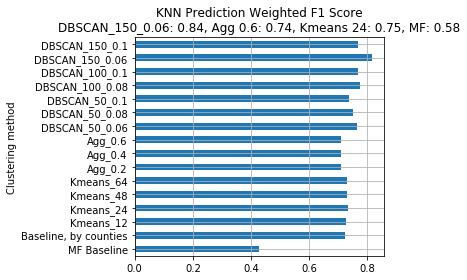

In [743]:
predict_mean_accuracy = pd.DataFrame(predict_accuracy_f1)
print(predict_mean_accuracy[2].mean())

ax = predict_mean_accuracy[2].plot(kind='barh', grid = True)
ax.set_yticklabels(predict_mean_accuracy[0])
pyplot.title('KNN Prediction Weighted F1 Score\nDBSCAN_150_0.06: {}, Agg 0.6: {}, Kmeans 24: {}, MF: {}'.format(round(predict_accuracy_f1[14][1], 2), round(predict_accuracy_f1[8][1], 2), round(predict_accuracy_f1[3][1], 2), round(predict_accuracy_f1[0][1], 2)))
pyplot.ylabel('Clustering method')
pyplot.tight_layout()

pyplot.savefig("Plots\KNN_F1.png")
pyplot.show()

## Training and testing the top performing classifier on the whole dataset

In [ ]:
#Trying to test DBSACN_150_.06 on data it has not seen yet, from outliers
clusters = DBSCAN(eps = 0.06, min_samples = 150).fit(coordPairs)
keydf['FIRE_SIZE'] = log_fire_size
keydf['CLUSTER_ID'] = clusters.labels_
burntime = []
for count in range(len(scan)):
    time = (scan.loc[count]["CONT_DOY"] - scan.loc[count]["DISCOVERY_DOY"])
    if (time==0) or pd.isna(time):
        time = 1
    burntime.append(time)

scan['BURN_DAYS'] = burntime
    
X = keydf.loc[:,["FIRE_SIZE", "FIRE_YEAR", "BURN_DAYS", "CLUSTER_ID", "DISCOVERY_DOY", "OWNER_CODE"]]
Y = keydf.loc[:, "STAT_CAUSE_CODE"]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.20, random_state=1)


#train KNN
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
#test KNN
predictions = model.predict(X_validation)
mean_accuracy = accuracy_score(Y_validation, predictions)
f1 = f1_score(Y_validation, predictions, average='weighted')
# Evaluate predictions
print("DBSCAN's accuracy for the map is {}".format(mean_accuracy))
print("DBSCAN's f1 for the map is {}".format(f1))

#train baseline
#model = DummyClassifier(strategy="most_frequent")
#model.fit(X_train, Y_train)
#test baseline
#predictions = model.predict(X_validation)
#mean_accuracy = accuracy_score(Y_validation, predictions)
#f1 = f1_score(Y_validation, predictions, average='weighted')
# Evaluate predictions
#print("The baseline's accuracy for the map is {}".format(mean_accuracy))
#print("The baseline's f1 for the map is {}".format(f1))



In [ ]:
#DBSCAN's accuracy for the map is 0.7439988290398126
#DBSCAN's f1 for the map is 0.7189388285774618
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [ ]:
#find all fires used for validation set, attach the predictions, then send to qgis to compare maps
valid_compare = []


for index in range(len(X_validation)):
    rownum = X_validation.iloc[index].name
    valid_compare.append(keydf.iloc[rownum])
    
validation_compare_df = pd.DataFrame(valid_compare)            

In [ ]:
validation_compare_df['STAT_CAUSE_PRED'] = predictions
print(validation_compare_df)



In [ ]:
#separate the correct classifications from the incorrect classifications
correct_in_pred = []


for index in range(len(validation_compare_df)):
    if (validation_compare_df['STAT_CAUSE_CODE'].iloc[index] == validation_compare_df['STAT_CAUSE_PRED'].iloc[index]):
        correct_in_pred.append(1)
    if (validation_compare_df['STAT_CAUSE_CODE'].iloc[index] != validation_compare_df['STAT_CAUSE_PRED'].iloc[index]):
        correct_in_pred.append(0)

validation_compare_df['CAUSE_PRED_CORRECT'] = correct_in_pred
#export and map in QGIS
#DBSCAN_150_06_correct_in = pd.DataFrame(correct_in_pred)
validation_compare_df.to_csv("DBSCAN_150_06_correct_in.csv")

#DBSCAN_150_06_incorrect = pd.DataFrame(incorrect_pred)
#DBSCAN_150_06_incorrect.to_csv("DBSCAN_150_06_incorrect.csv")


In [283]:
#importing county shapefile csvs and subtracting the fire counts in each county
#then it can be mapped
#This did not work#################################################

#correct = pd.read_csv('DBSCAN_150_06_correct_shape.csv')
#incorrect = pd.read_csv('DBSCAN_150_06_incorrect_shape.csv')

#classified_normal = []
#for index in range(len(correct)):
#    classified_normal.append(correct['NUMPOINTS'].iloc[index] - incorrect['NUMPOINTS'].iloc[index])
#print(classified_normal)

#correct['NUMPOINTS'] = classified_normal
#correct.to_csv('DBSCAN_150_06_normalized_pred.csv')

[32, -9, 19, 171, 10, -16, 6, 13, 15, 87, 12, -2, 2, -1, -2, 3, 19, 47, 2, 75, 32, 53, 231, 18, 62, 0, 13, 4, 89, 238, 3, 23, -2, 11, 16, 19, -2, 12, 1, 22, 0, 60, -3, 0, 2, 184, -5, 77, 20, 0, 460, 309, 193, 1, 44, 10, 30, 13, 31, 49, 512, 0, 16, 5]


## KNN Parameter Tuning

In [740]:
from sklearn.model_selection import GridSearchCV
#parameter tuning
clusters = DBSCAN(eps = 0.06, min_samples = 150).fit(coordPairs)
keydf['CLUSTER_ID'] = clusters.labels_

    
X = keydf.loc[:,["FIRE_SIZE", "FIRE_YEAR", "BURN_DAYS", "CLUSTER_ID", "DISCOVERY_DOY", "OWNER_CODE"]]
Y = keydf.loc[:, "STAT_CAUSE_CODE"]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.20, random_state=1)


leaf_size = list(range(20,40))
n_neighbors = list(range(4,25))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
#knn_2 = KNeighborsClassifier()
#Use GridSearch
#clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
#best_model = clf.fit(X,Y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 20
Best p: 2
Best n_neighbors: 24


In [741]:
model = KNeighborsClassifier(n_neighbors = 24, leaf_size = 20, p = 2)
model.fit(X_train, Y_train)

predictions = model.predict(X_validation)
mean_accuracy = accuracy_score(Y_validation, predictions)
f1 = f1_score(Y_validation, predictions, average='weighted')
# Evaluate predictions
print("DBSCAN's accuracy for the map is {}".format(mean_accuracy))
print("DBSCAN's f1 for the map is {}".format(f1))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))
#hmmmmm accuracy only improved by .01 and F1 dropped by .01, so negligible for tuning

DBSCAN's accuracy for the map is 0.7568793911007026
DBSCAN's f1 for the map is 0.7130875127414341
[[3826    0    0   74    3    0    4    0   82    1    0    0   34]
 [  41    0    0   10    1    0    1    0   34    0    0    0    7]
 [  58    0    1   19    2    0    1    0   63    0    0    0   19]
 [ 343    0    0  160    6    0   10    0   19    0    0    0   51]
 [  69    0    1   18    7    0    1    1   35    1    0    0   15]
 [  21    0    0    3    1    0    0    0    2    0    0    0    3]
 [  50    0    0   25    1    0    9    0   51    2    0    0   25]
 [  27    0    0    2    0    0    3    0    3    0    0    0    5]
 [ 141    0    0   37    7    0    1    0  710    0    0    0    9]
 [  24    0    0    0    0    1    0    0   12    4    0    0    0]
 [   8    0    0    1    0    0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    0    0    0    2    0    0    0    1]
 [  89    0    0   37    0    0   12    0   30    0    0    0  454]]
              pre

C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\dmruss\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#create new dataframe with 3 columns: xcoord, y coord, CLUSTER_ID
#coordPairs05 = pd.DataFrame()


#for item in dbscan05:
 #   xcoords.append(item[0])
#for item in coordPairs:
    #ycoords.append(item[1])
#coordPairs05.insert(0, "xcoord", xcoords)
#coordPairs05.insert(1, "ycoord", ycoords)
#coordPairs05.insert(2, "CLUSTER_ID", dbscan05['CLUSTER_ID'])


#create new dataframe with 3 columns: xcoord, y coord, CLUSTER_ID
#coordPairs07 = pd.DataFrame()
#xcoords07 = []
#ycoords07 = []
#for item in coordPairs:
 #   xcoords07.append(item[0])
#for item in coordPairs:
 #   ycoords07.append(item[1])
#coordPairs07.insert(0, "xcoord", xcoords07)
#coordPairs07.insert(1, "ycoord", ycoords07)
#coordPairs07.insert(2, "CLUSTER_ID", dbscan07['CLUSTER_ID'])\


#create new dataframe with 3 columns: xcoord, y coord, CLUSTER_ID
#coordPairs09 = pd.DataFrame()
#xcoords09 = []
#ycoords09 = []
#for item in coordPairs:
 #   xcoords09.append(item[0])
#for item in coordPairs:
 #   ycoords09.append(item[1])
#coordPairs09.insert(0, "xcoord", xcoords09)
#coordPairs09.insert(1, "ycoord", ycoords09)
#coordPairs09.insert(2, "CLUSTER_ID", dbscan09['CLUSTER_ID'])

In [ ]:
#drop all rows that contain NaN values for CLUSTER_ID, these are outliers
#print(coordPairs05.head())
#coordPairs05 = coordPairs05.dropna()
#print(coordPairs05.head())

#print(coordPairs07.head())
#coordPairs07 = coordPairs07.dropna()
#print(coordPairs07.head())

#print(coordPairs09.head())
#coordPairs09 = coordPairs09.dropna()
#print(coordPairs09.head())


In [ ]:
#separate pairs from cluster ids
#xcoord5 = coordPairs05['xcoord']
#ycoord5 = coordPairs05['ycoord']
#dbscan05clusterIDnonoise = coordPairs05['CLUSTER_ID']



#remCoordPairs5 = []
#for index in range(len(xcoord5)):
    
 #   current = []
    
  #  xval = xcoord5.iloc[index]
   # yval = ycoord5.iloc[index]
    #current.append(xval)
    #current.append(yval)
    #remCoordPairs5.append(current)

In [ ]:
#separate pairs from cluster ids
#xcoord7 = coordPairs07['xcoord']
#ycoord7 = coordPairs07['ycoord']
#dbscan07clusterIDnonoise = coordPairs07['CLUSTER_ID']



#remCoordPairs7 = []
#for index in range(len(xcoord7)):
    
 #   current = []
    
  #  xval = xcoord7.iloc[index]
   # yval = ycoord7.iloc[index]
   # current.append(xval)
   # current.append(yval)
   # remCoordPairs7.append(current)

In [ ]:
#separate pairs from cluster ids
#xcoord9 = coordPairs09['xcoord']
#ycoord9 = coordPairs09['ycoord']
#dbscan09clusterIDnonoise = coordPairs09['CLUSTER_ID']



#remCoordPairs9 = []
#for index in range(len(xcoord9)):
    
 #   current = []
    
  #  xval = xcoord9.iloc[index]
   # yval = ycoord9.iloc[index]
    #current.append(xval)
    #current.append(yval)
    #remCoordPairs9.append(current)

In [ ]:
#Find silhouette scores
#silScore05 = silhouette_score(remCoordPairs5, dbscan05clusterIDnonoise)
#silScore07 = silhouette_score(remCoordPairs7, dbscan07clusterIDnonoise)
#silScore09 = silhouette_score(remCoordPairs9, dbscan09clusterIDnonoise)

#silScores.append(["DBSCAN_"])

#DBSCANlist[0].append(silScore05)
#DBSCANlist[1].append(silScore07)
#DBSCANlist[2].append(silScore09)


#print(silScore05)
#print(silScore07)
#print(silScore09)


In [ ]:
#minpts = [50, 100, 150]
#epsilon = [.06, .08, .1]
#DBSCANclusters = []

#for pts in minpts:
 #   for E in epsilon:
  #      currentscan = DBSCAN(eps = E, min_samples = pts).fit(coordPairs)
   #     DBSCANclusters.append(currentscan)
    #    s = silhouette_score(coordPairs, currentscan.labels_)
     #   silScores.append(["DBSCAN_{}_{}".format(pts, E), s])
